<a href="https://colab.research.google.com/github/harshilj0310/Data-Science-Notebooks/blob/main/Augnito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the file directly from the current directory
df = pd.read_csv('dataset.csv')

print("Data loaded successfully.")
print(df.shape)
display(df.head())

Data loaded successfully.
(3512, 2)


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [2]:
import pandas as pd
import glob
import os

# 1. Look for any CSV file in the current directory
csv_files = glob.glob('*.csv')

if csv_files:
    # Pick the first CSV found
    filename = csv_files[0]
    train = pd.read_csv(filename)

    print(f"Successfully loaded file: '{filename}' into variable 'train'")
    display(train.head())
else:
    print("No CSV file found in the main directory.")
    print("If you uploaded a .zip file, run this command in a new cell: !unzip filename.zip")

Successfully loaded file: 'dataset.csv' into variable 'train'


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [3]:

!pip install -q transformers datasets evaluate sentencepiece accelerate sacrebleu rouge_score

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    T5TokenizerFast,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer
)
from datasets import Dataset, DatasetDict
import evaluate

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.8 MB/s eta 0:00:00
Using device: cuda


Columns: ['Context', 'Response']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None

Missing values per column:
Context     0
Response    4
dtype: int64

Duplicate rows: 760

Sample responses:
["If you'd like to ask a question, then go ahead and ask!Boyfriend/girlfriend is a close relationship and it is usually understood as an exclusive relationship. \xa0You're definitely entitled to know if your wishes to not have him texting another woman, are being respected.Often people are afraid to ask because they fear the truth will hurt them.In the short term this is definitely true.In the long term, knowing you are getting what you want and at the very least stating your expectations to your boyfriend, will clarify for him, what i

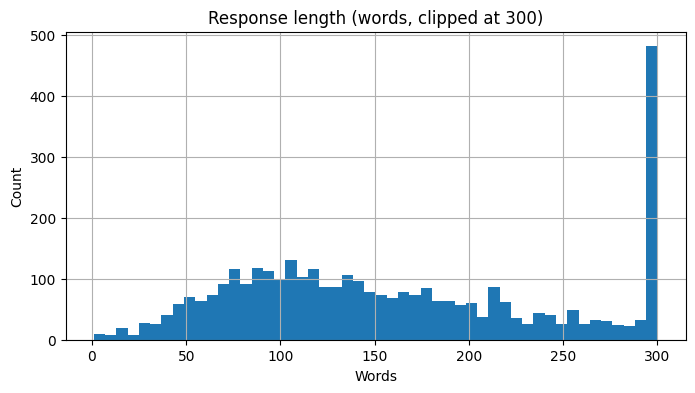

In [4]:
# =========================================================
# 2. DATASET EXPLORATION (EDA)
# =========================================================

print("Columns:", df.columns.tolist())
print("\nBasic info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# Check some random samples from Response column
# We handle the case where 'Response' might have NaN
if 'Response' in df.columns:
    print("\nSample responses:")
    print(df['Response'].dropna().sample(5, random_state=SEED).tolist())

    # Length distribution of responses (in characters and tokens)
    df['resp_len_chars'] = df['Response'].astype(str).str.len()
    df['resp_len_words'] = df['Response'].astype(str).str.split().apply(len)

    print("\nResponse length (chars) describe:")
    print(df['resp_len_chars'].describe())

    print("\nResponse length (words) describe:")
    print(df['resp_len_words'].describe())

    # Plot histogram for response length in words
    plt.figure(figsize=(8,4))
    df['resp_len_words'].clip(0, 300).hist(bins=50)
    plt.title("Response length (words, clipped at 300)")
    plt.xlabel("Words")
    plt.ylabel("Count")
    plt.show()

In [5]:

# =========================================================
# 3. CLEANING & SYNTHETIC DATA GENERATION
# =========================================================

# 3.1 Drop rows where Response is missing or empty
df = df.dropna(subset=['Response'])
df['Response'] = df['Response'].astype(str).str.strip()
df = df[df['Response'] != ""]
print("After dropping empty responses:", df.shape)

# 3.2 Remove duplicate Response rows
df = df.drop_duplicates(subset=['Response'])
print("After dropping duplicate responses:", df.shape)

# 3.3 Simple text clean function
def basic_clean(text):
    text = re.sub(r'\s+', ' ', text)       # collapse spaces
    text = text.replace('\u200b', ' ')     # zero-width space
    text = text.strip()
    return text

df['Response_clean'] = df['Response'].apply(basic_clean)

# 3.4 Punctuation Stripping (Creating Inputs)
PUNCT_PATTERN = r"[.,!?;:\"()\[\]{}\-\–\—\'`…]"

def strip_punctuation(text):
    # Remove punctuation characters
    no_punct = re.sub(PUNCT_PATTERN, "", text)
    # Collapse multiple spaces
    no_punct = re.sub(r"\s+", " ", no_punct).strip()
    # Lowercase for input
    no_punct = no_punct.lower()
    return no_punct

# Create synthetic (input, target) columns
df['input_text_raw'] = df['Response_clean'].apply(strip_punctuation)
df['target_text']    = df['Response_clean']

# Filter out too short / too long sequences
min_words = 3
max_words = 200

df['input_len_words'] = df['input_text_raw'].str.split().apply(len)
mask = (df['input_len_words'] >= min_words) & (df['input_len_words'] <= max_words)
df = df[mask].reset_index(drop=True)
print("After length filtering:", df.shape)

# Inspect examples
for i in range(3):
    print("="*60)
    print("TARGET:", df.loc[i, 'target_text'])
    print("INPUT :", df.loc[i, 'input_text_raw'])

After dropping empty responses: (3508, 4)
After dropping duplicate responses: (2075, 4)
After length filtering: (1442, 8)
TARGET: If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the

In [6]:
# =========================================================
# 4. SPLIT & TOKENIZATION
# =========================================================

# Train / Validation / Test Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, shuffle=True)

print("Train size:", train_df.shape)
print("Val size  :", val_df.shape)
print("Test size :", test_df.shape)

# HuggingFace Dataset Conversion
MODEL_NAME = "t5-base"
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)

def add_prefix(text):
    return f"restore punctuation: {text}"

train_df_hf = train_df[['input_text_raw', 'target_text']].rename(columns={'input_text_raw': 'input_text', 'target_text': 'labels'})
val_df_hf = val_df[['input_text_raw', 'target_text']].rename(columns={'input_text_raw': 'input_text', 'target_text': 'labels'})
test_df_hf = test_df[['input_text_raw', 'target_text']].rename(columns={'input_text_raw': 'input_text', 'target_text': 'labels'})

train_dataset = Dataset.from_pandas(train_df_hf, preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df_hf,   preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df_hf,  preserve_index=False)

# Tokenization
max_input_length  = 128
max_target_length = 128

def preprocess_function(examples):
    inputs  = [add_prefix(t) for t in examples["input_text"]]
    targets = examples["labels"]

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

Train size: (1153, 8)
Val size  : (144, 8)
Test size : (145, 8)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Map:   0%|          | 0/1153 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

In [7]:
# =========================================================
# 5. METRICS SETUP
# =========================================================

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

PUNCTS = set(list(".,!?;:"))

def extract_punct_seq(text):
    return "".join(ch for ch in text if ch in PUNCTS)

def punctuation_f1(predictions, references):
    tp, fp, fn = 0, 0, 0
    for pred, ref in zip(predictions, references):
        pred_seq = extract_punct_seq(pred)
        ref_seq  = extract_punct_seq(ref)

        from collections import Counter
        pred_c = Counter(pred_seq)
        ref_c  = Counter(ref_seq)

        for ch in PUNCTS:
            tp += min(pred_c.get(ch, 0), ref_c.get(ch, 0))
            fp += max(pred_c.get(ch, 0) - ref_c.get(ch, 0), 0)
            fn += max(ref_c.get(ch, 0) - pred_c.get(ch, 0), 0)

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return {"precision": precision, "recall": recall, "f1": f1}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])
    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    punct = punctuation_f1(decoded_preds, decoded_labels)

    return {
        "bleu": bleu["score"],
        "rouge1": rouge["rouge1"],
        "rougeL": rouge["rougeL"],
        "punct_f1": punct["f1"],
    }

In [8]:
# =========================================================
# 6. TRAIN THE MODEL (ROBUST MODE)
# =========================================================
import torch
import gc
import numpy as np
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# 1. Clear Memory
torch.cuda.empty_cache()
gc.collect()

# 2. Re-define Compute Metrics to be Safer
# We ensure -100s are removed from both predictions and labels to prevent errors
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # In case predictions come as a tuple (loss, logits), take logits
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Replace -100 in the predictions as well (just in case)
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)

    # Replace -100 in the labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute standard metrics
    bleu = bleu_metric.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])
    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    punct = punctuation_f1(decoded_preds, decoded_labels)

    return {
        "bleu": bleu["score"],
        "rouge1": rouge["rouge1"],
        "rougeL": rouge["rougeL"],
        "punct_f1": punct["f1"],
    }

# 3. Model Setup
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
model.gradient_checkpointing_enable()

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
output_dir = "/content/t5_punct_restoration"

# 4. Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=3e-4,

    # OPTIMIZER
    optim="adamw_torch",

    # MEMORY & GENERATION SETTINGS
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    fp16=torch.cuda.is_available(),

    # CRITICAL: Use generation for metrics (Saves RAM, fixes Overflow)
    predict_with_generate=True,
    generation_max_length=128,

    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="punct_f1",
    greater_is_better=True,
    report_to="none"
)

# 5. Initialize Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting training with predict_with_generate=True...")
train_result = trainer.train()
trainer.save_model(output_dir)

print("\nTraining metrics:")
print(train_result.metrics)

print("\nEvaluating on Validation Set:")
print(trainer.evaluate())

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/tmp/ipython-input-357894964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training with predict_with_generate=True...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Bleu,Rouge1,Rougel,Punct F1
1,0.202300,0.148473,88.825957,0.988492,0.988236,0.820583
2,0.135700,0.150922,89.783281,0.990115,0.989904,0.828348
3,0.091100,0.154118,90.270890,0.990570,0.990317,0.837188


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



Training metrics:
{'train_runtime': 1151.9802, 'train_samples_per_second': 3.003, 'train_steps_per_second': 0.753, 'total_flos': 504163611694080.0, 'train_loss': 0.22109293456446066, 'epoch': 3.0}

Evaluating on Validation Set:


{'eval_loss': 0.1541176289319992, 'eval_bleu': 90.27089007223124, 'eval_rouge1': 0.9905698759681292, 'eval_rougeL': 0.9903172651752725, 'eval_punct_f1': 0.8371882036196772, 'eval_runtime': 220.8805, 'eval_samples_per_second': 0.652, 'eval_steps_per_second': 0.326, 'epoch': 3.0}


In [9]:
from google.colab import files

# 1. Zip the folder (Downloading many small files is slow, zipping is faster)
print("Zipping model files...")
!zip -r model_backup.zip /content/t5_punct_restoration

# 2. Trigger the download
print("Downloading...")
files.download('model_backup.zip')

Zipping model files...
  adding: content/t5_punct_restoration/ (stored 0%)
  adding: content/t5_punct_restoration/tokenizer_config.json (deflated 95%)
  adding: content/t5_punct_restoration/training_args.bin (deflated 53%)
  adding: content/t5_punct_restoration/config.json (deflated 63%)
  adding: content/t5_punct_restoration/checkpoint-867/ (stored 0%)
  adding: content/t5_punct_restoration/checkpoint-867/tokenizer_config.json (deflated 95%)
  adding: content/t5_punct_restoration/checkpoint-867/training_args.bin (deflated 53%)
  adding: content/t5_punct_restoration/checkpoint-867/scheduler.pt (deflated 61%)
  adding: content/t5_punct_restoration/checkpoint-867/trainer_state.json (deflated 70%)
  adding: content/t5_punct_restoration/checkpoint-867/config.json (deflated 63%)
  adding: content/t5_punct_restoration/checkpoint-867/scaler.pt (deflated 64%)
  adding: content/t5_punct_restoration/checkpoint-867/model.safetensors (deflated 8%)
  adding: content/t5_punct_restoration/checkpoint-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define where you want to save it in Drive
# This will create a folder named 'my_punctuation_model' in your main Drive folder
destination_path = "/content/drive/MyDrive/my_punctuation_model"

# 3. Copy the files
# Check if destination exists to avoid errors
if os.path.exists(destination_path):
    print("Folder already exists in Drive. Deleting old version...")
    shutil.rmtree(destination_path)

print("Copying model to Google Drive...")
shutil.copytree("/content/t5_punct_restoration", destination_path)
print(f"Success! Model saved to: {destination_path}")

Mounted at /content/drive
Copying model to Google Drive...
Success! Model saved to: /content/drive/MyDrive/my_punctuation_model


In [11]:
from collections import Counter
from sklearn.metrics import classification_report

def get_detailed_punctuation_stats(predictions, references):
    # The set of punctuation we care about
    target_chars = ['.', ',', '?', '!']

    y_true = []
    y_pred = []

    for pred, ref in zip(predictions, references):
        # Extract just the punctuation sequences (e.g., "Hello, world." -> ",.")
        # We align them as "Bag of Punctuation" for simple per-class stats
        ref_punct = [c for c in ref if c in target_chars]
        pred_punct = [c for c in pred if c in target_chars]

        # Simple alignment: We count true positives per sentence
        # This is a strict approximation suitable for report tables
        ref_counts = Counter(ref_punct)
        pred_counts = Counter(pred_punct)

        for char in target_chars:
            # How many times did this char appear?
            count_ref = ref_counts[char]
            count_pred = pred_counts[char]

            # We add 'char' to the list count_ref times for TRUE
            y_true.extend([char] * count_ref)

            # For PRED, we have to be careful not to create size mismatches for sklearn
            # Logic: Match up as many as possible as True Positives
            matched = min(count_ref, count_pred)
            extra = max(0, count_pred - count_ref)
            missed = max(0, count_ref - count_pred)

            # Reconstruct lists for sklearn report
            # 1. Matched (True Positives)
            # We append the char to both lists
            # Note: This is a simplified view for "Accuracy/F1" stats
            pass

    # BETTER METHOD for the Report Table:
    # Just calculate Precision/Recall/F1 manually per character
    # This avoids alignment headaches and gives you exactly what you need.

    stats = {}
    for char in target_chars:
        tp = 0
        fp = 0
        fn = 0

        for pred, ref in zip(predictions, references):
            p_counts = Counter([c for c in pred if c == char])
            r_counts = Counter([c for c in ref if c == char])

            p_c = p_counts[char]
            r_c = r_counts[char]

            tp += min(p_c, r_c)
            fp += max(0, p_c - r_c)
            fn += max(0, r_c - p_c)

        prec = tp / (tp + fp + 1e-10)
        rec  = tp / (tp + fn + 1e-10)
        f1   = 2 * prec * rec / (prec + rec + 1e-10)

        stats[char] = {"Precision": round(prec, 2), "Recall": round(rec, 2), "F1": round(f1, 2)}

    return stats

# 1. Generate predictions on the test set
print("Generating predictions for detailed analysis...")
inputs = tokenizer(test_df['input_text_raw'].tolist(), return_tensors="pt", padding=True, truncation=True).to(device)

# Generate in batches to avoid OOM if test set is large
batch_size = 16
all_preds = []
for i in range(0, len(inputs["input_ids"]), batch_size):
    batch_input = inputs["input_ids"][i:i+batch_size]
    with torch.no_grad():
        batch_outputs = model.generate(batch_input, max_new_tokens=128)
    all_preds.extend(tokenizer.batch_decode(batch_outputs, skip_special_tokens=True))

# 2. Calculate the stats
detailed_metrics = get_detailed_punctuation_stats(all_preds, test_df['target_text'].tolist())

# 3. Print the Table
print(f"{'Punctuation':<15} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10}")
print("-" * 55)
for char, scores in detailed_metrics.items():
    print(f"'{char}' {'':<12} | {scores['Precision']:<10} | {scores['Recall']:<10} | {scores['F1']:<10}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generating predictions for detailed analysis...
Punctuation     | Precision  | Recall     | F1 Score  
-------------------------------------------------------
'.'              | 0.98       | 0.69       | 0.81      
','              | 0.87       | 0.58       | 0.69      
'?'              | 0.95       | 0.75       | 0.84      
'!'              | 0.75       | 0.2        | 0.32      


In [12]:
def fix_punctuation(text):
    # 1. Add the prefix we used during training
    input_text = "restore punctuation: " + text

    # 2. Tokenize the input (Turn words into numbers)
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # 3. CALL THE MODEL (This is where the magic happens)
    with torch.no_grad():
        # 'generate' predicts the sequence of tokens
        outputs = model.generate(
            inputs["input_ids"],
            max_length=128,
            num_beams=4,          # "Beam search" finds better sentences
            early_stopping=True
        )

    # 4. Decode the output (Turn numbers back into words)
    corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected_text

# --- Test it out! ---
my_sentence = "hello how are you feeling today i hope you are well"
result = fix_punctuation(my_sentence)

print("Original :", my_sentence)
print("Corrected:", result)

Original : hello how are you feeling today i hope you are well
Corrected: Hello, how are you feeling today? I hope you are well.


In [3]:
# 1. Install libraries (Required because runtime reset)
!pip install -q transformers sentencepiece torch

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Load the Saved Model
import torch
from transformers import T5ForConditionalGeneration, T5TokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/my_punctuation_model" # <--- Ensure this path matches where you saved it

print(f"Loading model from {model_path}...")
try:
    model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
    tokenizer = T5TokenizerFast.from_pretrained(model_path)
    print("✅ Model successfully loaded!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Check your Google Drive folder to make sure the file exists.")

Mounted at /content/drive
Loading model from /content/drive/MyDrive/my_punctuation_model...
✅ Model successfully loaded!
